# Import Library

In [1]:
pip install split-folders

In [2]:
import tensorflow as tf
from tensorflow import keras
# print(tf.keras.__version__)
import numpy as np
import matplotlib.pyplot as plt
import splitfolders

# Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import zipfile

local_zip = 'drive/My Drive/dataset/Prak. ML/Modul 6/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r') # Membaca local path
zip_ref.extractall('/tmp') # Extract .zip file
zip_ref.close()

In [6]:
#splittin
splitfolders.ratio('/tmp/rps', output="/tmp/modul6", seed=1337, ratio=(.7, 0.25,0.05))

Copying files: 2520 files [00:00, 3056.62 files/s]


In [7]:
# Definisikan path untuk data train dan data validation

base_dir = '/tmp/modul6'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

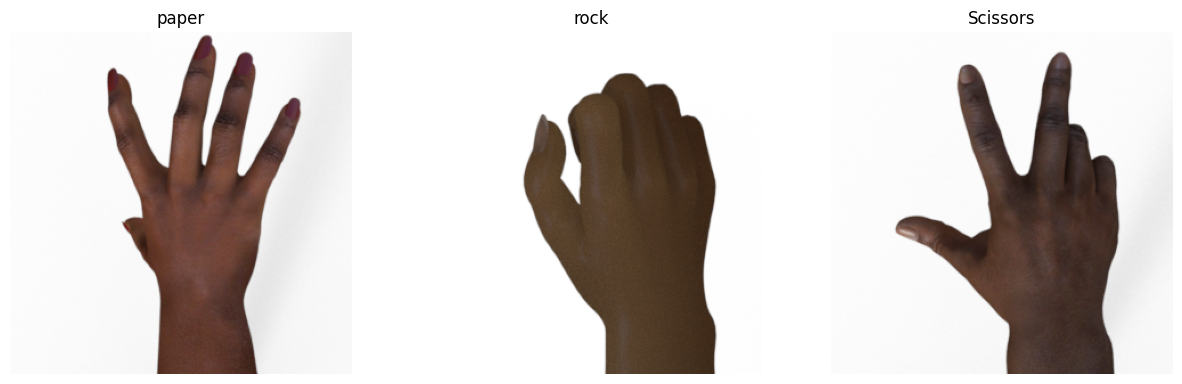

In [8]:
import random
from tensorflow.keras.preprocessing.image import load_img

# Membuat plot dengan dua kolom subplot yang berada dalam satu baris
fig, ax = plt.subplots(1, 3, figsize=(15, 10)) # figsize() untuk set ukurang gambar

sample_paper = random.choice(os.listdir(train_dir + "/paper")) # library random digunakan untuk memilih data secara acak
image = load_img(train_dir + "/paper/" + sample_paper) # library load_img digunakan untuk memuat gambar dengan path yang sudah ditentukan
# set gambar untuk kolom pertama (index 0)
ax[0].imshow(image)
ax[0].set_title("paper")
ax[0].axis("Off")

sample_rock = random.choice(os.listdir(train_dir + "/rock"))
image = load_img(train_dir + "/rock/" + sample_rock)
# set gambar untuk kolom kedua (index 1)
ax[1].imshow(image)
ax[1].set_title("rock")
ax[1].axis("Off")

sample_scissors = random.choice(os.listdir(train_dir + "/scissors"))
image = load_img(train_dir + "/scissors/" + sample_scissors)
# set gambar untuk kolom kedua (index 1)
ax[2].imshow(image)
ax[2].set_title("Scissors")
ax[2].axis("Off")

plt.show()

# Pre-Processing

In [9]:
# normalize the scale in every images using ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

datagen     = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    shear_range=0.2,               # Menambahkan shear transformation dengan kisaran 20%
                    height_shift_range=0.2,        # Menambahkan pergeseran tinggi dengan kisaran 20%
                    fill_mode='nearest')

# implement ImageDataGenerator in train data
train_gen = datagen.flow_from_directory(train_dir, #Direktori data
                                             target_size=(150, 150), #Target size image
                                             batch_size=32, #Menerapkan batch size
                                             class_mode='categorical') #Menerapkan mode kelas

Found 1764 images belonging to 3 classes.


In [10]:
val_gen = datagen.flow_from_directory(validation_dir,
                                      target_size=(150, 150),
                                      batch_size=32,
                                      class_mode='categorical')

# Menampilkan informasi banyak batch data yang digunakan dalam pelatihan dan training
print('Batches train=%d, validation=%d' % (len(train_gen), len(val_gen)))

Found 630 images belonging to 3 classes.
Batches train=56, validation=20


In [11]:
# Fungsi ini akan memplot gambar dalam bentuk grid dengan 1 baris dan 5 kolom, di mana gambar ditempatkan di setiap kolom.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

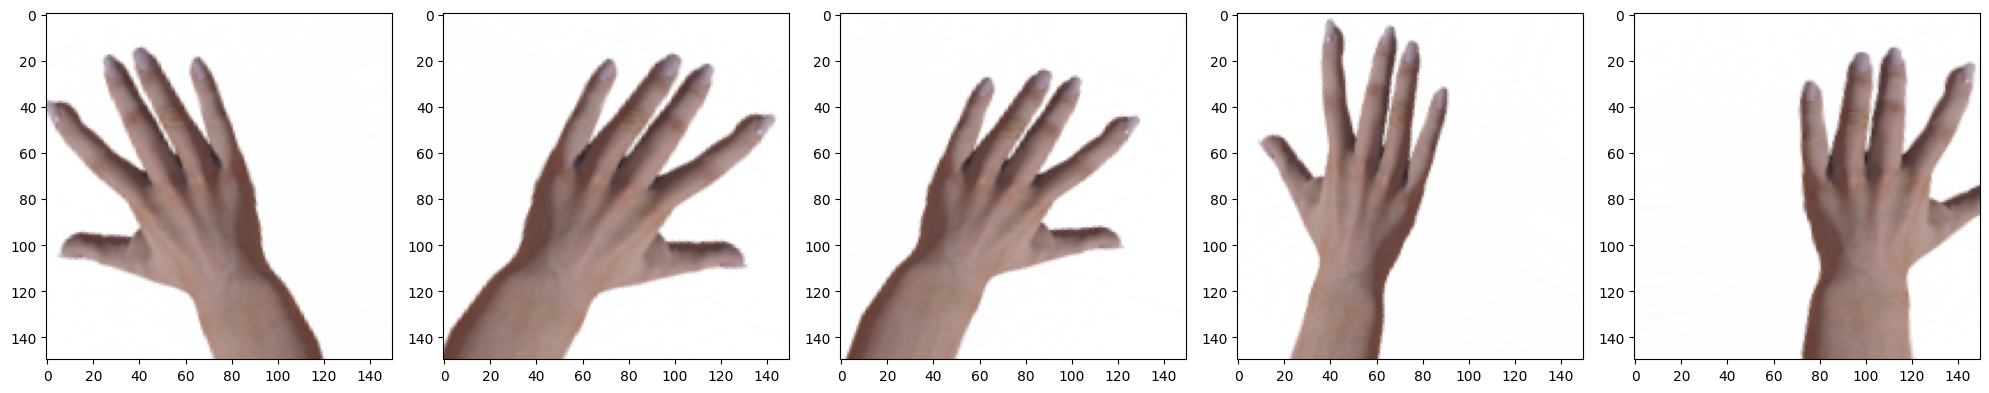

In [12]:
# Visualisasi Data Train yang sudah di-augmentasi
augmented_images = [train_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# MobileNet Model

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications import MobileNet

In [14]:
MN_baseModel = MobileNet(
                      weights="imagenet",  # Load weights pre-trained on ImageNet.
                      input_tensor=Input(shape=(150, 150, 3)), # Set Input Model dengan shape yang sesuai dengan ukuran citra
                      include_top=False,
                      )

17225924/17225924 [==============================] - 0s 0us/step


In [15]:
# Model Summary
MN_baseModel.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 75, 75, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 75, 75, 32) 

In [16]:
# Freeze the baseModel karena sudah dilakukan training
MN_baseModel.trainable = False

In [17]:
MN_model = tf.keras.Sequential([
    MN_baseModel,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [18]:
# Model Summary yang kita buat
MN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 1024)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 3)                 12291     
                                                                 
Total params: 3241155 (12.36 MB)
Trainable params: 12291 (48.01 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [19]:
MN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [20]:
MN_history = MN_model.fit(train_gen,
          validation_data=val_gen,
          steps_per_epoch=20, epochs=10)

Epoch 1/10
20/20 [==============================] - 43s 2s/step - loss: 1.4695 - categorical_accuracy: 0.6687 - val_loss: 0.3844 - val_categorical_accuracy: 0.8952
Epoch 2/10
20/20 [==============================] - 60s 3s/step - loss: 0.2026 - categorical_accuracy: 0.9375 - val_loss: 0.1050 - val_categorical_accuracy: 0.9619
Epoch 3/10
20/20 [==============================] - 38s 2s/step - loss: 0.0978 - categorical_accuracy: 0.9703 - val_loss: 0.0275 - val_categorical_accuracy: 0.9873
Epoch 4/10
20/20 [==============================] - 37s 2s/step - loss: 0.0460 - categorical_accuracy: 0.9869 - val_loss: 0.0266 - val_categorical_accuracy: 0.9889
Epoch 5/10
20/20 [==============================] - 38s 2s/step - loss: 0.0479 - categorical_accuracy: 0.9828 - val_loss: 0.0293 - val_categorical_accuracy: 0.9905
Epoch 6/10
20/20 [==============================] - 45s 2s/step - loss: 0.0451 - categorical_accuracy: 0.9828 - val_loss: 0.0322 - val_categorical_accuracy: 0.9921
Epoch 7/10
20/20

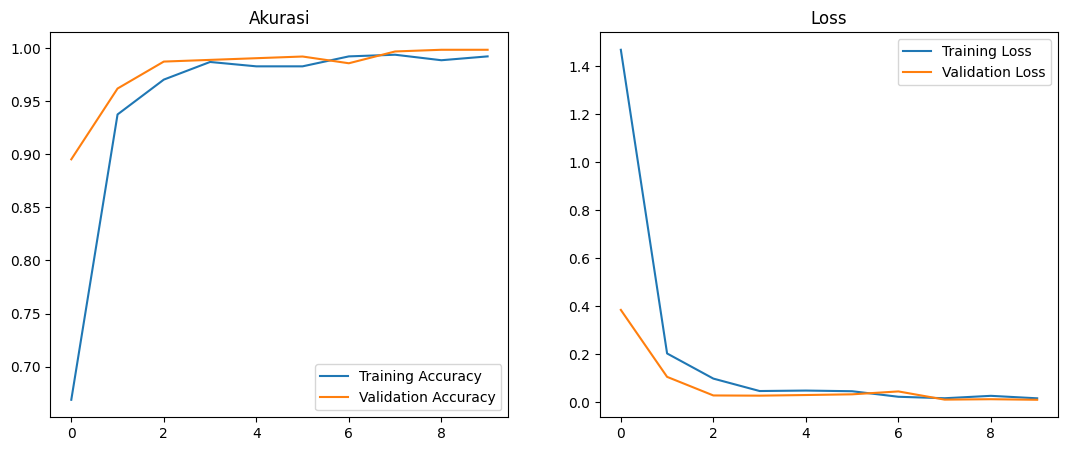

In [21]:
# Visualization Accuracy, Val Accuracy, Loss and Val Loss
import matplotlib.pyplot as plt

acc = MN_history.history['categorical_accuracy']
val_acc = MN_history.history['val_categorical_accuracy']
loss = MN_history.history['loss']
val_loss = MN_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [22]:
# Printout Accuracy and Loss
loss, accuracy = MN_model.evaluate_generator(val_gen)
print("Validation: \nAccuracy = %f  \nLoss = %f " % (accuracy, loss))

<ipython-input-22-7e9c11eeafa2>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = MN_model.evaluate_generator(val_gen)


Validation: 
Accuracy = 0.996825  
Loss = 0.009266 


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Memperoleh prediksi probabilitas untuk setiap sampel dalam dataset validasi
y_pred = MN_model.predict(val_gen )

# Mengambil indeks kelas dengan probabilitas tertinggi untuk setiap sampel
y_pred_classes = np.argmax(y_pred, axis=1)

# Mengambil indeks kelas sebenarnya dari dataset validasi
true_classes = val_gen .classes

# Mendapatkan nama kelas dari indeks kelas
class_labels = list(val_gen .class_indices.keys())

# Menampilkan classification report
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

20/20 [==============================] - 22s 936ms/step
              precision    recall  f1-score   support

       paper       0.33      0.32      0.33       210
        rock       0.32      0.32      0.32       210
    scissors       0.37      0.38      0.38       210

    accuracy                           0.34       630
   macro avg       0.34      0.34      0.34       630
weighted avg       0.34      0.34      0.34       630



In [25]:
MN_model.save('MobileNet.h5')

# Save the model
MN_model_save_path = 'path/to/save/your/MobileNet.h5'
MN_model.save(MN_model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
from keras.models import load_model

MN_model = load_model('MobileNet.h5')

In [27]:
def load_and_preprocess_images(folder, label, num_images=10):
    image_paths = [os.path.join(folder, file) for file in os.listdir(folder)]
    random.shuffle(image_paths)
    images = []
    labels = []

    for i, image_path in enumerate(image_paths):
        if i >= num_images:
            break

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        image = cv2.resize(image, (150, 150))  # Resize the image to match your model input size
        image = image / 255.0  # Normalize pixel values to [0, 1]

        images.append(image)

        # Extract the label from the folder name
        labels.append(label)

    return np.array(images), labels

In [30]:
import cv2
num_images = 4
rock_images, rock_labels = load_and_preprocess_images('/tmp/modul6/test/rock', 'rock', num_images)
paper_images, paper_labels = load_and_preprocess_images('/tmp/modul6/test/paper', 'paper', num_images)
scissors_images, scissors_labels = load_and_preprocess_images('/tmp/modul6/test/scissors', 'scissors', num_images)

In [31]:
images = np.vstack((rock_images, paper_images, scissors_images))
true_labels = rock_labels + paper_labels + scissors_labels
predictions = MN_model.predict(images)
label_mapping = {0: "paper", 1: "rock", 2: "scissor"}
predicted_labels = [label_mapping[np.argmax(prediction)] for prediction in predictions]

1/1 [==============================] - 1s 634ms/step


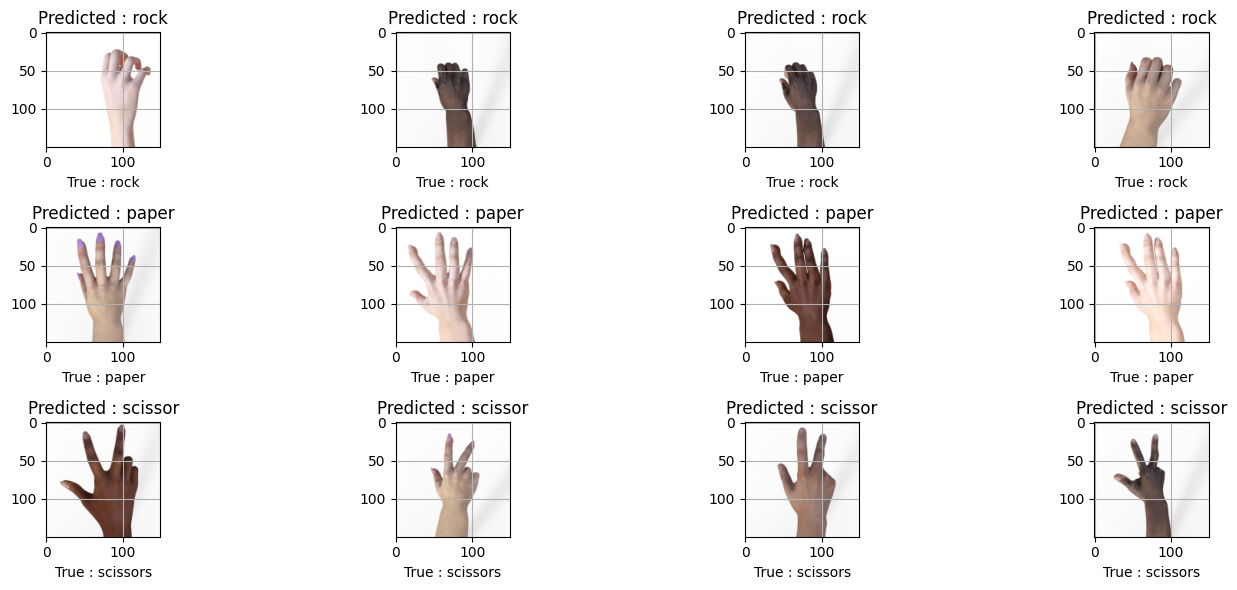

In [32]:
plt.figure(figsize=(15, 6))
for i in range(num_images * 3):
    plt.subplot(3, num_images, i + 1)
    plt.tight_layout()
    plt.imshow(images[i])
    plt.title(f"Predicted : {predicted_labels[i]}")
    plt.xlabel(f"True : {true_labels[i]}")
    plt.grid(visible=None)

plt.show()

# ResNet

In [74]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications import ResNet101

In [75]:
# Kita load model ResNet101, kemudian kita potong bagian Top atau Fully Connected Layernya
RN_baseModel = ResNet101(
                      weights="imagenet",  # Load weights pre-trained on ImageNet.
                      input_tensor=Input(shape=(150, 150, 3)), # Set Input Model dengan shape yang sesuai dengan ukuran citra
                      include_top=False,
                      )

In [76]:
# Model Summary
RN_baseModel.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_12[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [77]:
# Freeze the baseModel karena sudah dilakukan training
RN_baseModel.trainable = False

In [78]:
RN_model = tf.keras.Sequential([
    RN_baseModel,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [79]:
# Model Summary yang kita buat
RN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 5, 5, 2048)        42658176  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 3)                 24579     
                                                                 
Total params: 42682755 (162.82 MB)
Trainable params: 24579 (96.01 KB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________


In [80]:
RN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [81]:
RN_history = RN_model.fit(train_gen,
          validation_data=val_gen,
          steps_per_epoch=20, epochs=10)

Epoch 1/10
20/20 [==============================] - 315s 16s/step - loss: 1.0188 - categorical_accuracy: 0.4984 - val_loss: 0.9218 - val_categorical_accuracy: 0.5349
Epoch 2/10
20/20 [==============================] - 258s 13s/step - loss: 0.8579 - categorical_accuracy: 0.6438 - val_loss: 0.8551 - val_categorical_accuracy: 0.6032
Epoch 3/10
20/20 [==============================] - 224s 11s/step - loss: 0.8019 - categorical_accuracy: 0.6618 - val_loss: 0.7701 - val_categorical_accuracy: 0.6540
Epoch 4/10
20/20 [==============================] - 253s 13s/step - loss: 0.7465 - categorical_accuracy: 0.7173 - val_loss: 0.6887 - val_categorical_accuracy: 0.7714
Epoch 5/10
20/20 [==============================] - 226s 12s/step - loss: 0.6702 - categorical_accuracy: 0.7437 - val_loss: 0.6514 - val_categorical_accuracy: 0.7508
Epoch 6/10
20/20 [==============================] - 261s 13s/step - loss: 0.6257 - categorical_accuracy: 0.7734 - val_loss: 0.6149 - val_categorical_accuracy: 0.8016
Epoc

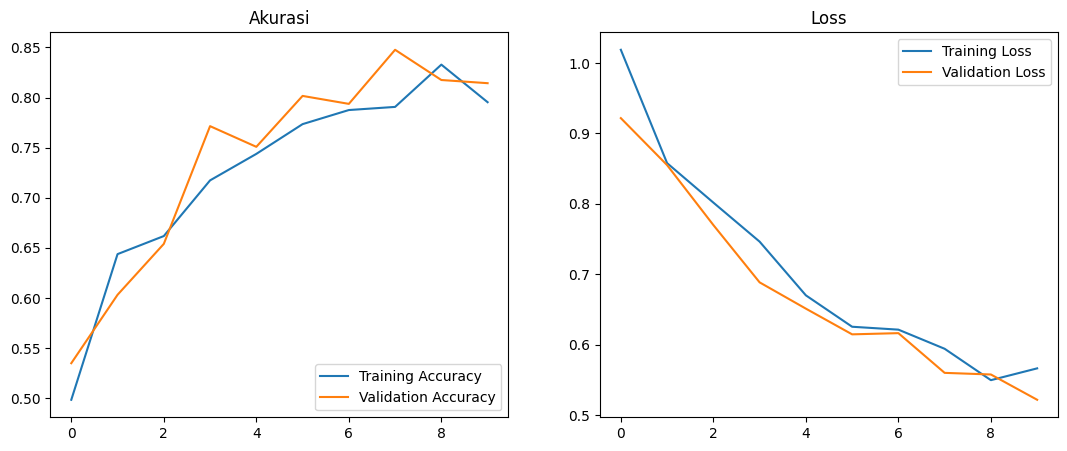

In [82]:
# Visualization Accuracy, Val Accuracy, Loss and Val Loss

import matplotlib.pyplot as plt

acc = RN_history.history['categorical_accuracy']
val_acc = RN_history.history['val_categorical_accuracy']
loss = RN_history.history['loss']
val_loss = RN_history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [83]:
# Printout Accuracy and Loss
loss, accuracy = RN_model.evaluate_generator(val_gen)
print("Validation: \nAccuracy = %f  \nLoss = %f " % (accuracy, loss))

<ipython-input-83-a2653ac0a827>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = RN_model.evaluate_generator(val_gen)


Validation: 
Accuracy = 0.811111  
Loss = 0.529685 


In [84]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Memperoleh prediksi probabilitas untuk setiap sampel dalam dataset validasi
y_pred = RN_model.predict(val_gen )

# Mengambil indeks kelas dengan probabilitas tertinggi untuk setiap sampel
y_pred_classes = np.argmax(y_pred, axis=1)

# Mengambil indeks kelas sebenarnya dari dataset validasi
true_classes = val_gen .classes

# Mendapatkan nama kelas dari indeks kelas
class_labels = list(val_gen .class_indices.keys())

# Menampilkan classification report
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))

20/20 [==============================] - 118s 6s/step
              precision    recall  f1-score   support

       paper       0.38      0.35      0.36       210
        rock       0.37      0.49      0.42       210
    scissors       0.30      0.22      0.25       210

    accuracy                           0.35       630
   macro avg       0.35      0.35      0.35       630
weighted avg       0.35      0.35      0.35       630



In [86]:
RN_model.save('ResNet.h5')

# Save the model
RN_model_save_path = 'path/to/save/your/ResNet.h5'
RN_model.save(RN_model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
from keras.models import load_model

RN_model = load_model('ResNet.h5')

In [88]:
def load_and_preprocess_images(folder, label, num_images=10):
    image_paths = [os.path.join(folder, file) for file in os.listdir(folder)]
    random.shuffle(image_paths)
    images = []
    labels = []

    for i, image_path in enumerate(image_paths):
        if i >= num_images:
            break

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        image = cv2.resize(image, (150, 150))  # Resize the image to match your model input size
        image = image / 255.0  # Normalize pixel values to [0, 1]

        images.append(image)

        # Extract the label from the folder name
        labels.append(label)

    return np.array(images), labels

In [89]:
import cv2
num_images = 4
rock_images, rock_labels = load_and_preprocess_images('/tmp/modul6/test/rock', 'rock', num_images)
paper_images, paper_labels = load_and_preprocess_images('/tmp/modul6/test/paper', 'paper', num_images)
scissors_images, scissors_labels = load_and_preprocess_images('/tmp/modul6/test/scissors', 'scissors', num_images)

In [90]:
images = np.vstack((rock_images, paper_images, scissors_images))
true_labels = rock_labels + paper_labels + scissors_labels
predictions = model.predict(images)
label_mapping = {0: "paper", 1: "rock", 2: "scissor"}
predicted_labels = [label_mapping[np.argmax(prediction)] for prediction in predictions]

1/1 [==============================] - 5s 5s/step


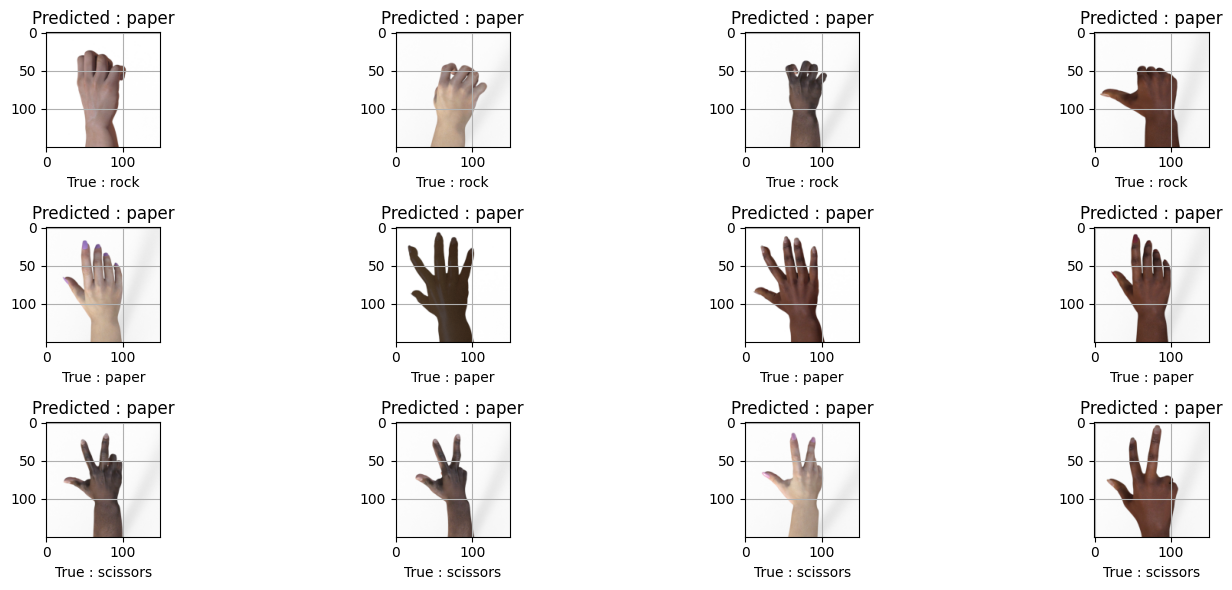

In [91]:
plt.figure(figsize=(15, 6))
for i in range(num_images * 3):
    plt.subplot(3, num_images, i + 1)
    plt.tight_layout()
    plt.imshow(images[i])
    plt.title(f"Predicted : {predicted_labels[i]}")
    plt.xlabel(f"True : {true_labels[i]}")
    plt.grid(visible=None)

plt.show()